<a href="https://colab.research.google.com/github/Aurorcys/TRY-BEAT-S-P-WITH-ML-EXCEPT-DIE/blob/main/TwoCharts_SPY_VIX%2C_INCL_ML%2C_XBGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1887449611.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datas = yf.download('SPY', period='2y')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1887449611.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datav = yf.download('^VIX', period='2y')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1887449611.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


Data shape: (441, 15)
Backtesting...
[np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.0), np.float64(10000.

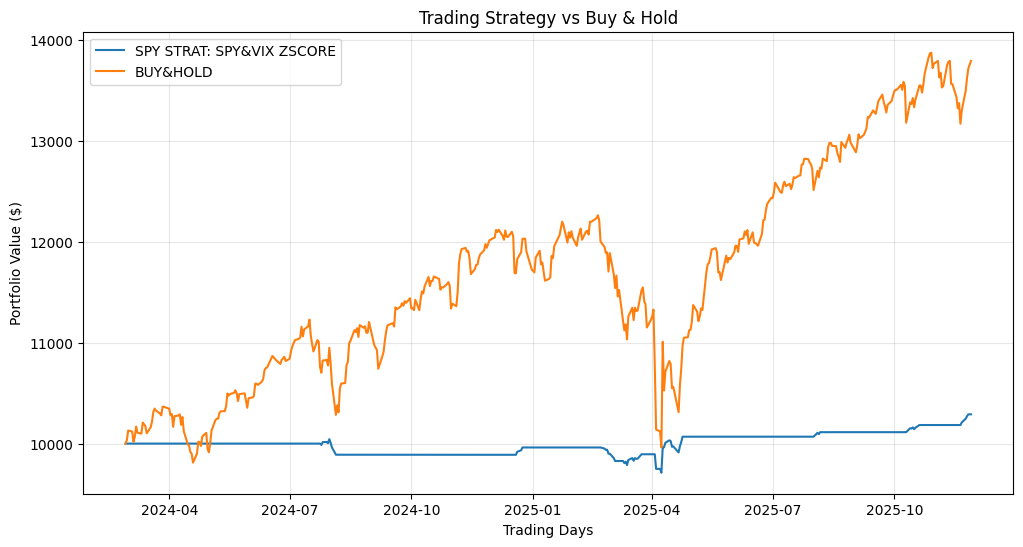

Number of Trades:
22
FINAL VALUATION $$
10289.940799550264


In [61]:
from curl_cffi.requests.impersonate import TLS_EC_CURVES_MAP
from typing_extensions import dataclass_transform
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

period = '2y'


def zsc():
    datas = yf.download('SPY', period='2y')
    datav = yf.download('^VIX', period='2y')

    # Create DataFrames with proper indexing
    com = pd.DataFrame(index=datas.index)
    com['SPYCLOSE'] = datas['Close']
    com['SPYVOL'] = datas['Volume']

    # Align VIX data (might have different dates)
    com['VIXCLOSE'] = datav['Close'].reindex(com.index).ffill()

    # Remove any NaN rows
    com = com.dropna()

    # Calculate spread and z-score
    com['Spread'] = com['SPYCLOSE'] - com['VIXCLOSE']
    com['SPREADMEAN'] = com['Spread'].rolling(window=20).mean()
    com['SPREADSTD'] = com['Spread'].rolling(window=20).std()
    com['SpreadZ'] = (com['Spread'] - com['SPREADMEAN']) / com['SPREADSTD']
    com['VolumeSPY'] = datas['Volume']
    com['VOLMA20'] = com['SPYVOL'].rolling(window=20).mean()
    com['VOLRA'] = com['VolumeSPY'] / com['VOLMA20']


    # Replace infinite values with NaN
    com['SpreadZ'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Calculate VIX percentile
    com['VIXPER'] = com['VIXCLOSE'].rolling(window=60).rank(pct=True)

    com['HIGH'] = datas['High'].reindex(com.index).ffill()
    com['LOW'] = datas['Low'].reindex(com.index).ffill()

    com['TR'] = np.maximum(
        com['HIGH'] - com['LOW'],
        np.maximum(
            abs(com['HIGH'] - com['SPYCLOSE'].shift(1)),
            abs(com['LOW'] - com['SPYCLOSE'].shift(1))
        )
    )

    com['ATR'] = com['TR'].rolling(window=14).mean()

    # Drop NaN rows (from rolling calculations)
    com = com.dropna()

    return com

data = zsc()
print(f"Data shape: {data.shape}")

#to include:
  #z score conditions
  #volume conditions
  #tp and sl based on atr
  #maybe news data with ml?

  #steps
  #first: z score backtest
  #second: add volume
  #third: add tp and sl on atr calculation
  #fourth: new code block and understand alternative data

#initial conditions
cash = 10000
shares = 0
trades = []
portfolio = []
position = 0
entry = 0
sl = 0
tp = 0

# Risk parameters
RISK_PER_TRADE = 0.15      # Risk 2% of portfolio per trade
STOP_LOSS_ATR_MULT = 2.0   # Stop loss at 2× ATR below entry
TAKE_PROFIT_ATR_MULT = 3.0 # Take profit at 3× ATR above entry


print('Backtesting...')
for i in range(len(data)):
  currentclose = data['SPYCLOSE'].iloc[i]
  current_date = data.index[i]
  currentz = data['SpreadZ'].iloc[i]
  current_atr = data['ATR'].iloc[i]
  current_vol = data['VOLRA'].iloc[i]

  if position == 0 and currentz <= -0.8 and current_vol > 1.5 and i >= 1:
    #underextended
    max_dollar_risk = portfolio[-1] * RISK_PER_TRADE
    atr_stop_dollars = current_atr * STOP_LOSS_ATR_MULT

    if atr_stop_dollars > 0:
        sharestobuy = max_dollar_risk / atr_stop_dollars
    else:
        sharestobuy = 0
    max_pos = portfolio[-1] * 0.25
    max_shares = max_pos / currentclose


    sharestobuy = min(sharestobuy, max_shares)
    if sharestobuy * currentclose < 10:
        continue

    cost = sharestobuy * currentclose
    if cost <= cash:
      shares += sharestobuy
      entry = currentclose
      cash -= cost

      position = 1

      sl = entry - (current_atr * STOP_LOSS_ATR_MULT)
      tp = entry + (current_atr* TAKE_PROFIT_ATR_MULT)

      risk_per = entry - sl
      tolrisk = risk_per * sharestobuy
      riskpct = (tolrisk / portfolio[-1]) * 100

      trades.append({
          'date': current_date,
          'type': 'BUY',
          'entry': entry,
          'shares': sharestobuy,
          'cost': cost,
          'sl': sl,
          'tp': tp,
          'risk_pct': riskpct,
          'z_score': currentz,
          'atr': current_atr
      })

  elif position == 1:
    profitpct = ((currentclose - entry ) / entry)* 100
    exit = False
    reason = ''
    if currentclose <= sl:
      exit = True
      reason = f'STOP LOSS {profitpct:.1f}%'

    elif currentclose >= tp:
      exit = True
      reason = f'TAKE PROFIT {profitpct:.1f}%'

    elif currentz >= 0.4:
      exit = True
      reason = f'Z SCORE {currentz:.1f}'

    if exit:
      saleval = shares*currentclose
      cash += saleval
      tradepro = saleval - (entry*shares)
      tradepropct = (tradepro / (entry*shares)) * 100


      trades.append({
          'date': current_date,
          'type': 'SELL',
          'price': currentclose,
          'shares': shares,
          'profit': tradepro,
          'profit_pct': tradepropct,
          'reason': reason

      })
      shares = 0
      position = 0
      sl = 0
      tp = 0
      entry = 0
      saleval = 0
  portfolio.append(cash + shares*currentclose)

print(portfolio)


casb = 10000
sharesb = 0
portfoliob = []
for i in range(len(data)):
  currentclose = data['SPYCLOSE'].iloc[i]
  if i == 0:
    sharesb += casb / currentclose
    casb = 0
  portfoliob.append(sharesb*currentclose)

plt.figure(figsize=(12, 6))
plt.plot(data.index, portfolio, label='SPY STRAT: SPY&VIX ZSCORE')
plt.plot(data.index, portfoliob, label='BUY&HOLD')
plt.title('Trading Strategy vs Buy & Hold')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Trading Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


print('Number of Trades:')
print(len(trades))


print('\nFINAL VALUATION $$')
print(f"Strategy: ${portfolio[-1]:,.2f}")
print(f"Buy & Hold: ${portfoliob[-1]:,.2f}")


#THIS IS AAASSSSAASASAASS



In [90]:
#MLLLLL
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def zsc():
    datas = yf.download('SPY', period='2y')
    datav = yf.download('^VIX', period='2y')

    # Create DataFrames with proper indexing
    com = pd.DataFrame(index=datas.index)
    com['SPYCLOSE'] = datas['Close']
    com['SPYVOL'] = datas['Volume']

    # Align VIX data (might have different dates)
    com['VIXCLOSE'] = datav['Close'].reindex(com.index).ffill()

    # Remove any NaN rows
    com = com.dropna()

    # Calculate spread and z-score
    com['Spread'] = com['SPYCLOSE'] - com['VIXCLOSE']
    com['SPREADMEAN'] = com['Spread'].rolling(window=20).mean()
    com['SPREADSTD'] = com['Spread'].rolling(window=20).std()
    com['SpreadZ'] = (com['Spread'] - com['SPREADMEAN']) / com['SPREADSTD']
    com['VolumeSPY'] = datas['Volume']
    com['VOLMA20'] = com['SPYVOL'].rolling(window=20).mean()
    com['VOLRA'] = com['VolumeSPY'] / com['VOLMA20']


    # Replace infinite values with NaN
    com['SpreadZ'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Calculate VIX percentile
    com['VIXPER'] = com['VIXCLOSE'].rolling(window=60).rank(pct=True)

    com['HIGH'] = datas['High'].reindex(com.index).ffill()
    com['LOW'] = datas['Low'].reindex(com.index).ffill()

    com['TR'] = np.maximum(
        com['HIGH'] - com['LOW'],
        np.maximum(
            abs(com['HIGH'] - com['SPYCLOSE'].shift(1)),
            abs(com['LOW'] - com['SPYCLOSE'].shift(1))
        )
    )

    com['ATR'] = com['TR'].rolling(window=14).mean()

    # Drop NaN rows (from rolling calculations)
    com = com.dropna()

    return com

features = ['VOLRA', 'SpreadZ', 'ATR', 'SPYVOL']
df = zsc()
df['Future_Return'] = (df['SPYCLOSE'].shift(-7) / df['SPYCLOSE'] - 1) * 100
df['Tmr_Class'] = pd.cut(df['Future_Return'],
                         bins=[-np.inf, -0.1, 0.1, np.inf],
                         labels=[-1, 0, 1])

df = df.dropna()

X = df[features]
y = df['Tmr_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'\nModel Accuracy: {accuracy:.1%}')

print('\nFeature Importance')
feature_names = features
importances = model.feature_importances_

for name, importance in zip(feature_names, importances):
  print(f'{name}: {importance:.1%}')


#this be pretty good, 33 is prob, but we get 51, les go.

/tmp/ipython-input-2788847277.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datas = yf.download('SPY', period='2y')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2788847277.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datav = yf.download('^VIX', period='2y')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2788847277.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



Model Accuracy: 66.7%

Feature Importance
VOLRA: 21.4%
SpreadZ: 28.6%
ATR: 27.1%
SPYVOL: 23.0%


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2010460639.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  com['SpreadZ'].replace([np.inf, -np.inf], np.nan, inplace=True)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:31:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used

✅ XGBoost Buy/Sell Accuracy: 59.2%
10232.129563817454
5
46
[{'date': Timestamp('2025-10-22 00:00:00'), 'risk': np.float32(0.17220151), 'type': 'BUY', 'probability': np.float32(0.8555038), 'shares': np.float64(3.6984278303342903), 'cost': np.float64(1765.9253610601586)}, {'date': Timestamp('2025-10-23 00:00:00'), 'type': 'SELL', 'probability': np.float32(0.31444925), 'profit': np.float64(1761.0434092360229), 'shares': np.float64(3.6984278303342903), 'reason': 'PROBABILITY 0.3'}, {'date': Timestamp('2025-10-24 00:00:00'), 'risk': np.float32(0.07531526), 'type': 'BUY', 'probability': np.float32(0.61328816), 'shares': np.float64(1.6253785643120953), 'cost': np.float64(771.9897890169399)}, {'date': Timestamp('2025-10-27 00:00:00'), 'type': 'SELL', 'probability': np.float32(0.23426774), 'profit': np.float64(776.4595800687982), 'shares': np.float64(1.6253785643120953), 'reason': 'PROBABILITY 0.2'}, {'date': Timestamp('2025-10-30 00:00:00'), 'risk': np.float32(0.18493482), 'type': 'BUY', 'prob

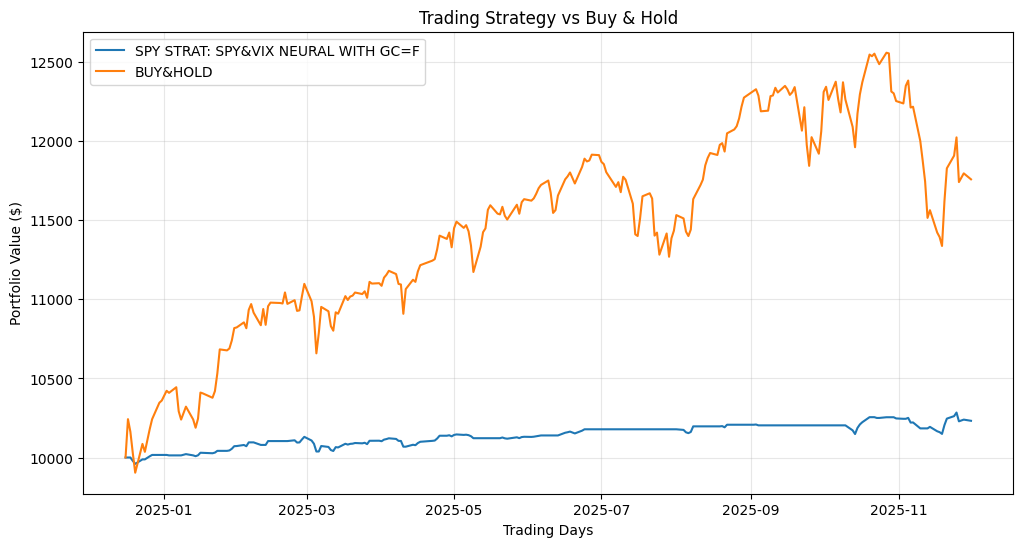

=====FINAL RESULTS HOMEBOY=====
this is so ass
STRATEGY FINAL VAL: 10232.1
BH FINAL VAL: 11758.9
PROFIT PERCENTAGE: 2.3%


In [50]:
#XBGC TIMEEEE
#buy and sell predictor first
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import yfinance as yf
import matplotlib.pyplot as plt

def zsc():
    datas = yf.download('SPY', period='5y', auto_adjust=False)  # Explicitly set
    datav = yf.download('^VIX', period='5y', auto_adjust=False)
    gol = yf.download('GC=F', period='5y', auto_adjust=False)

    # Create DataFrames with proper indexing
    com = pd.DataFrame(index=datas.index)
    com['SPYCLOSE'] = datas['Close']
    com['SPYVOL'] = datas['Volume']


    # Align VIX data (might have different dates)
    com['VIXCLOSE'] = datav['Close'].reindex(com.index).ffill()
    com['GOLDCLOSE'] = gol['Close'].reindex(com.index).ffill()
    # Remove any NaN rows
    com = com.dropna()

    # Calculate spread and z-score
    com['GOLD_SPY_Ratio'] = com['GOLDCLOSE'] / com['SPYCLOSE']
    com['Spread'] = com['SPYCLOSE'] - com['VIXCLOSE']
    com['SPREADMEAN'] = com['Spread'].rolling(window=20).mean()
    com['SPREADSTD'] = com['Spread'].rolling(window=20).std()
    com['SpreadZ'] = (com['Spread'] - com['SPREADMEAN']) / com['SPREADSTD']
    com['VolumeSPY'] = datas['Volume']
    com['VOLMA20'] = com['SPYVOL'].rolling(window=20).mean()
    com['VOLRA'] = com['VolumeSPY'] / com['VOLMA20']


    # Replace infinite values with NaN
    com['SpreadZ'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Calculate VIX percentile
    com['VIXPER'] = com['VIXCLOSE'].rolling(window=60).rank(pct=True)

    com['HIGH'] = datas['High'].reindex(com.index).ffill()
    com['LOW'] = datas['Low'].reindex(com.index).ffill()

    com['TR'] = np.maximum(
        com['HIGH'] - com['LOW'],
        np.maximum(
            abs(com['HIGH'] - com['SPYCLOSE'].shift(1)),
            abs(com['LOW'] - com['SPYCLOSE'].shift(1))
        )
    )

    com['ATR'] = com['TR'].rolling(window=14).mean()

    # Drop NaN rows (from rolling calculations)
    com = com.dropna()

    return com

features = ['VOLRA', 'SpreadZ', 'ATR', 'SPYVOL', 'Spread', 'GOLD_SPY_Ratio']
df = zsc()
df['Tmr Up'] = (df['SPYCLOSE'].shift(-5) > df['SPYCLOSE']).astype(int)

df = df.dropna()

X = df[features]
y = df['Tmr Up']

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"✅ XGBoost Buy/Sell Accuracy: {accuracy:.1%}")

#51.9 what the actual heLL???

cash = 10000
shares = 0
portfolio = []
trades = []
position = 0
entry = 0
sl = 0
tp = 0
num = 0

STOP_LOSS_ATR_MULT = 2.0   # Stop loss at 2× ATR below entry
TAKE_PROFIT_ATR_MULT = 3.0

for i in range(len(X_test)):
  currentf = X_test.iloc[i:i+1]
  currentclose = df['SPYCLOSE'].iloc[i]
  current_atr = df['ATR'].iloc[i]

  prob = model.predict_proba(currentf)[0][1]

  if prob > 0.55 and position == 0:
    risk = 0.05 + (prob - 0.55) * 0.40 #max at 19.99999999...
    sharestobuy = cash*risk / currentclose
    trades.append({
        'date': X_test.index[i],
        'risk': risk,
        'type': 'BUY',
        'probability': prob,
        'shares': sharestobuy,
        'cost': risk*cash
    })
    cash -= risk*cash
    shares += sharestobuy
    position = 1
    entry = currentclose

    sl = entry - (current_atr * STOP_LOSS_ATR_MULT)
    tp = entry + (current_atr* TAKE_PROFIT_ATR_MULT)

  elif position == 1:
    profitpct = ((currentclose - entry ) / entry) * 100
    exit = False
    reason = ''
    if currentclose <= sl:
      exit = True
      reason = f'STOP LOSS {profitpct:.1f}%'
      num += 1

    elif currentclose >= tp:
      exit = True
      reason = f'TAKE PROFIT {profitpct:.1f}%'
      num += 1

    elif prob <= 0.4:
      exit = True
      reason = f'PROBABILITY {prob:.1f}'

    if exit:
      cash += shares*currentclose
      trades.append({
          'date': X_test.index[i],
          'type': 'SELL',
          'probability': prob,
          'profit': shares*currentclose,
          'shares': shares,
          'reason': reason
      })
      shares = 0
      position = 0
      sl = 0
      tp = 0
      entry = 0

  portfolio.append(cash + shares*currentclose)

print(portfolio[-1])
print(num)
print(len(trades))
print(trades[-10:])

casb = 10000
sharesb = 0
portfoliob = []
for i in range(len(X_test)):
  currentclose = df['SPYCLOSE'].iloc[i]
  if i == 0:
    sharesb += casb / currentclose
    casb = 0
  portfoliob.append(casb + sharesb*currentclose)

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, portfolio, label='SPY STRAT: SPY&VIX NEURAL WITH GC=F')
plt.plot(X_test.index, portfoliob, label='BUY&HOLD')
plt.title('Trading Strategy vs Buy & Hold')
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Trading Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('=====FINAL RESULTS HOMEBOY=====')
print('this is so ass')
print(f'STRATEGY FINAL VAL: {portfolio[-1]:.1f}')
print(f'BH FINAL VAL: {portfoliob[-1]:.1f}')
print(f'PROFIT PERCENTAGE: {((portfolio[-1] - 10000) / 10000 * 100):.1f}%')
